<a href="https://colab.research.google.com/github/abhinav70291/TechnicalAnalysis-for-intra-day-trading/blob/main/Abhinav_technical_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **df IMPORTS**

**Importing Dependencies**

In [3]:
!pip install -q --upgrade ipywidgets matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Reading  df**

In [90]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'sma', 'sma_short',
       'sma_long', 'ema', 'ema_short', 'ema_long', 'rsi', 'short_ema',
       'long_ema', 'macd_line', 'signal_line', 'macd_histogram', 'delta_Close',
       'delta_Volume', 'sma_short_over_long', 'ema_short_over_long',
       'macd_over_signal', 'price_over_sma', 'price_over_ema', 'std',
       'upper_bb', 'lower_bb', 'pullback', 'target', 'Close_lag_1',
       'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5',
       'Close_lag_6', 'Close_lag_7', 'obv'],
      dtype='object')

In [ ]:
df=pd.read_csv("/content/Manappuram_10minute.csv")
df.tail(50)

In [45]:
# Converting Date column into datetime dftype
df.Date= pd.to_datetime(df['Date'])

<Axes: xlabel='Date'>

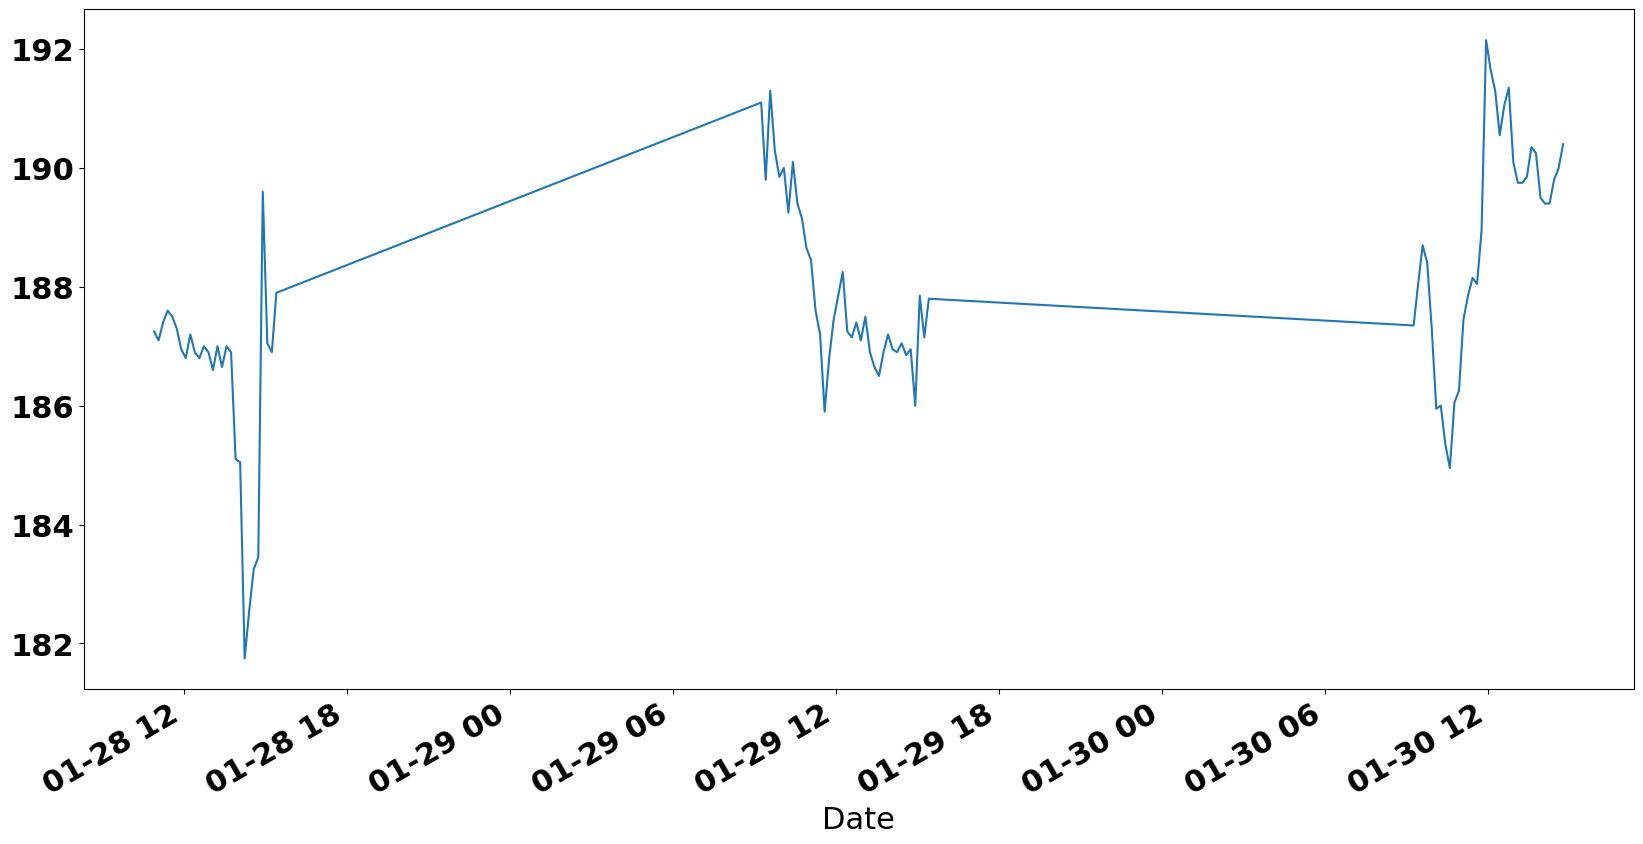

In [105]:
df.Close[200:300].plot(figsize=(20,10))

<Axes: xlabel='Date'>

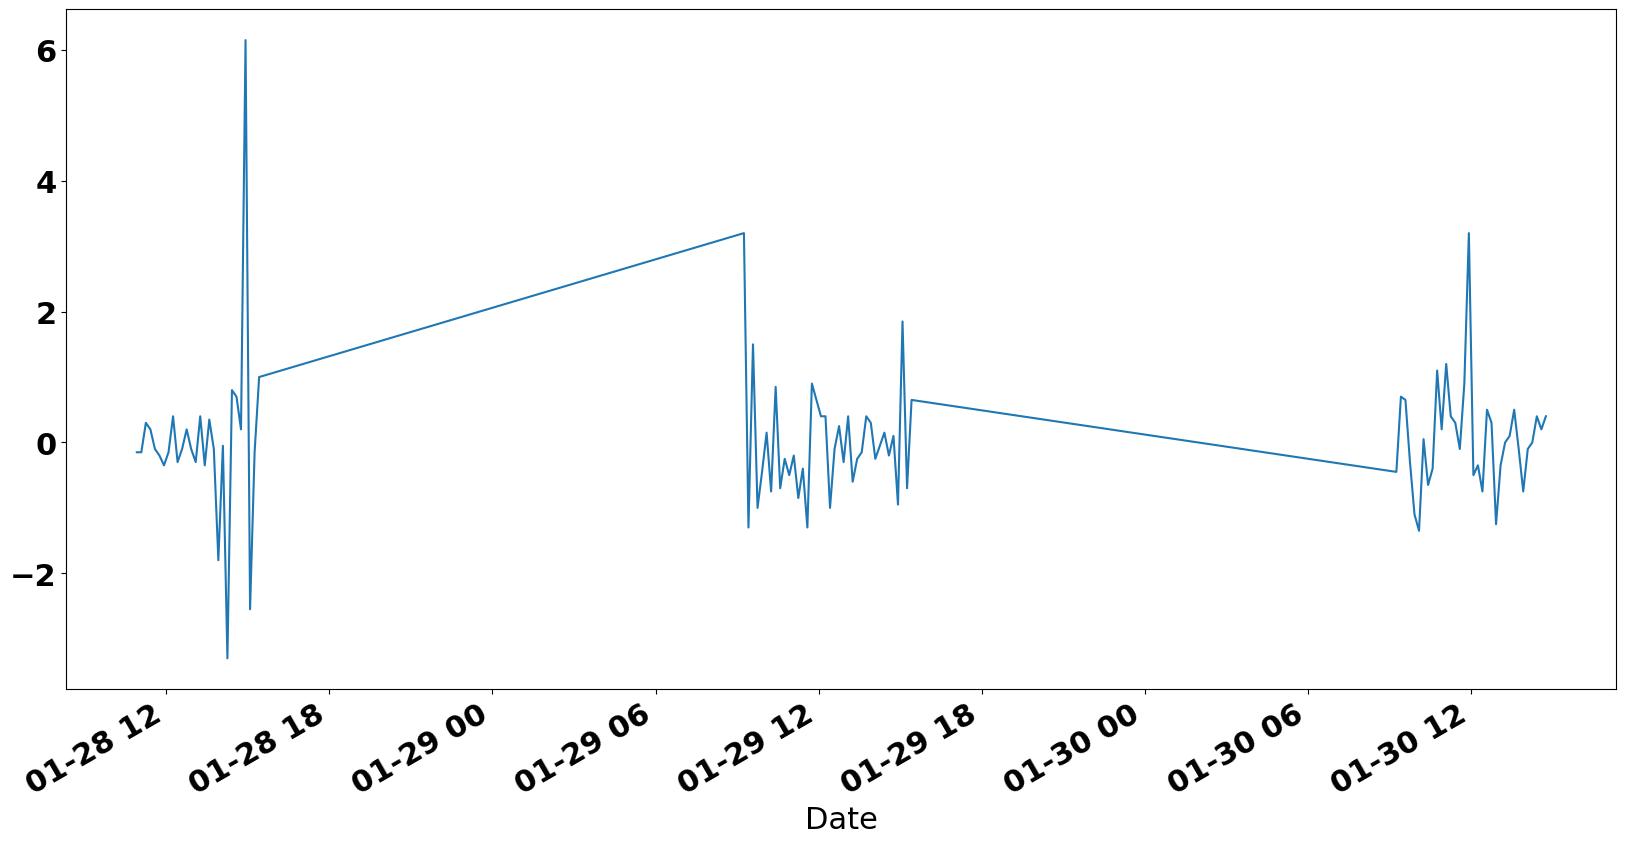

In [103]:
# df.Close[200:300].plot(figsize=(20,10))
df["delta_Close"][200:300].plot(figsize=(20,10))
# df["sma_long"][200:300].plot(figsize=(20,10))

<Axes: xlabel='Date'>

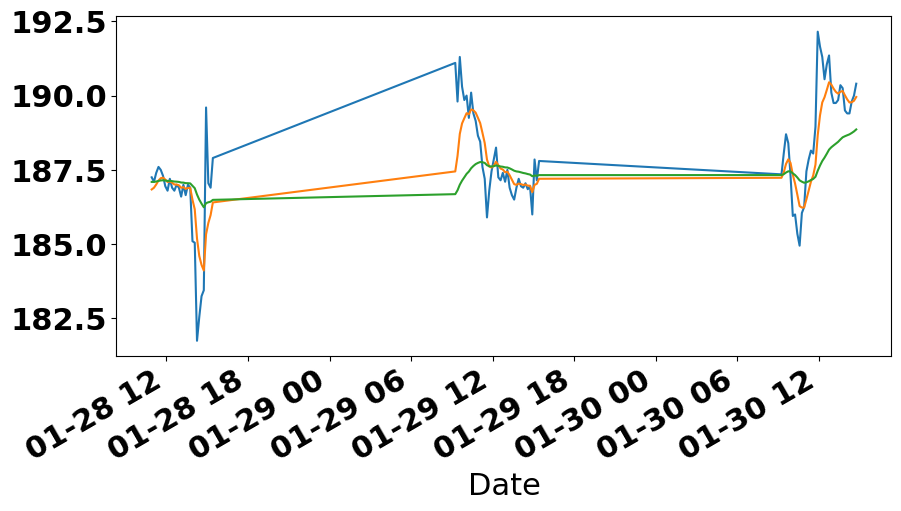

In [94]:
df.Close[200:300].plot(figsize=(10,5))
df["ema_short"][200:300].plot(figsize=(10,5))
df["ema_long"][200:300].plot(figsize=(10,5))

<Axes: xlabel='Date'>

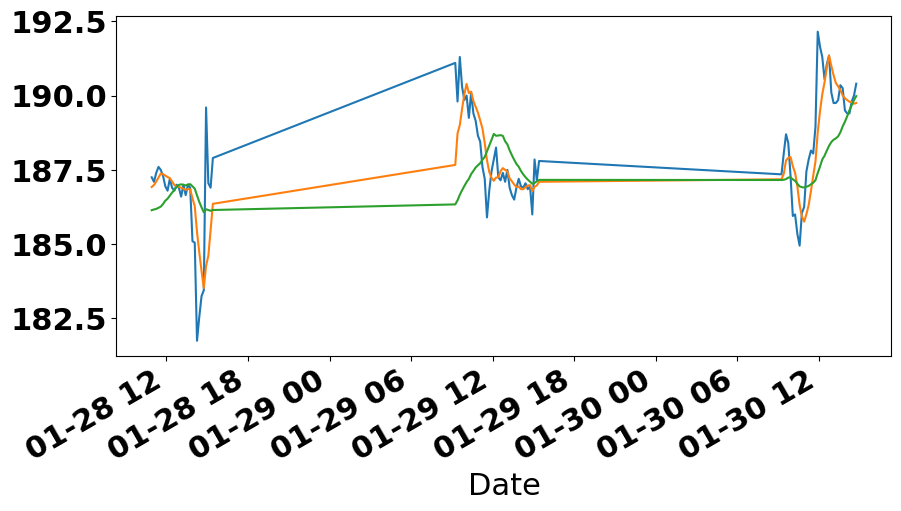

In [95]:
df.Close[200:300].plot(figsize=(10,5))
df["sma_short"][200:300].plot(figsize=(10,5))
df["sma_long"][200:300].plot(figsize=(10,5))

**Can uncomment this code below to provide date ranges and work with limited df**

In [ ]:
# start_date = '2020-01-21'
# end_date   = '2020-01-24'
# df = df.query('Date >= @start_date and Date <= @end_date')

In [ ]:
# Creating price column, which is basically the opening price of the following day
# df["price"]=df.Open.shift(-1)

In [46]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


# **Backtesting strategies and optimizing rolling window/other parameters from here**

**SMA window opimization**

For parameter: 2, Hit Rate: 0.030303030303030304, Profit Factor: 0.5879544007631773, Sharpe Ratio: -3.3592080772785287
For parameter: 3, Hit Rate: 0.045454545454545456, Profit Factor: 0.76225866821412, Sharpe Ratio: -1.540047368649168
For parameter: 4, Hit Rate: 0.045454545454545456, Profit Factor: 0.9639385788711465, Sharpe Ratio: -0.2498451548310155
For parameter: 5, Hit Rate: 0.06060606060606061, Profit Factor: 1.0992140721275152, Sharpe Ratio: 0.8629026725492593
For parameter: 6, Hit Rate: 0.09090909090909091, Profit Factor: 2.0374604648369856, Sharpe Ratio: 6.191683740938391
For parameter: 7, Hit Rate: 0.09090909090909091, Profit Factor: 1.7689161523671975, Sharpe Ratio: 5.12392878144264
For parameter: 8, Hit Rate: 0.07575757575757576, Profit Factor: 1.9546904677817252, Sharpe Ratio: 5.226784441942988
For parameter: 9, Hit Rate: 0.045454545454545456, Profit Factor: 1.043047197678036, Sharpe Ratio: 0.31904813395389886
For parameter: 10, Hit Rate: 0.045454545454545456, Profit Factor

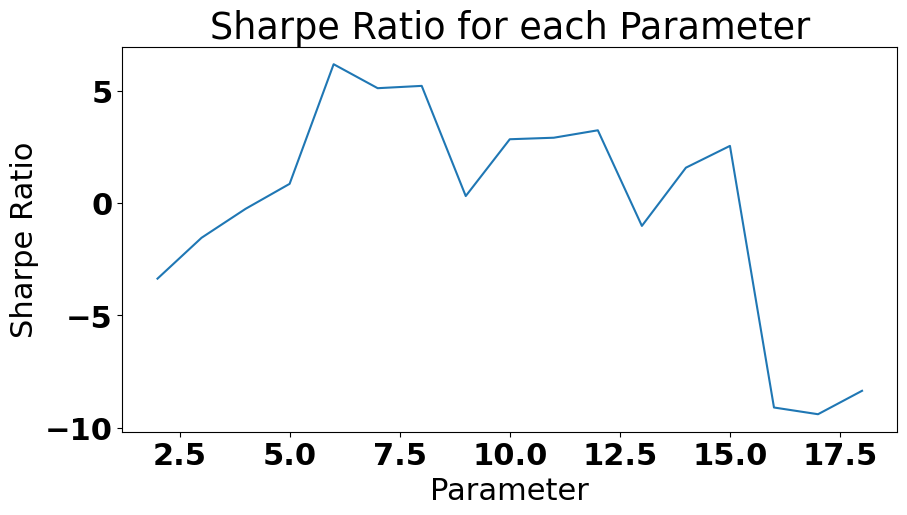

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# calculates SMA using "n" as the rolling window size
def ma_calc(df, n):
  df["sma"] = df.Close.rolling(window=n).mean()
  return df

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = ma_calc(df, n)
  in_position = False
  daily_profits = []
  capital = starting_capital

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.Close > row.sma and row.Volume > volume_limit:
          buyprice = row.Close
          investment = min(max(capital * 0.01, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row.Close < row.sma or row.Close < buyprice * (1 - stop_loss):
          profits.append((row.Close - buyprice) / buyprice)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()

  return hit_rate, profit_factor, sharpe_ratio


# Initialize a dictionary to store metrics for each parameter
metrics_dict = {}

# Run the loop and find the optimal parameters
starting_capital = 10000  # Starting capital in your currency
stop_loss = 0.02  # Stop loss level (2% in this case)
upper_cap = 1000  # Upper investment cap in your currency
lower_cap = 100  # Lower investment cap in your currency
transaction_cost = 0.001  # Transaction cost (0.1% in this case)
leverage = 1 # Leverage (2x in this case)
volume_percentage = 0.2  # Minimum average daily volume

for n in range(2, 19):
  hit_rate, profit_factor, sharpe_ratio = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)  # replace volume_limit with volume_percentage
  print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}")
  metrics_dict[n] = (hit_rate, profit_factor, sharpe_ratio)


# Find the parameter with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter with maximum Sharpe Ratio is: {max_sharpe_param}")

# Add the feature with optimized value
df = ma_calc(df, max_sharpe_param)

# Plot the Sharpe Ratios
plt.figure(figsize=(10,5))
plt.plot(list(metrics_dict.keys()), [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter')
plt.show()


**window optmization for short term and long term SMA crossover**

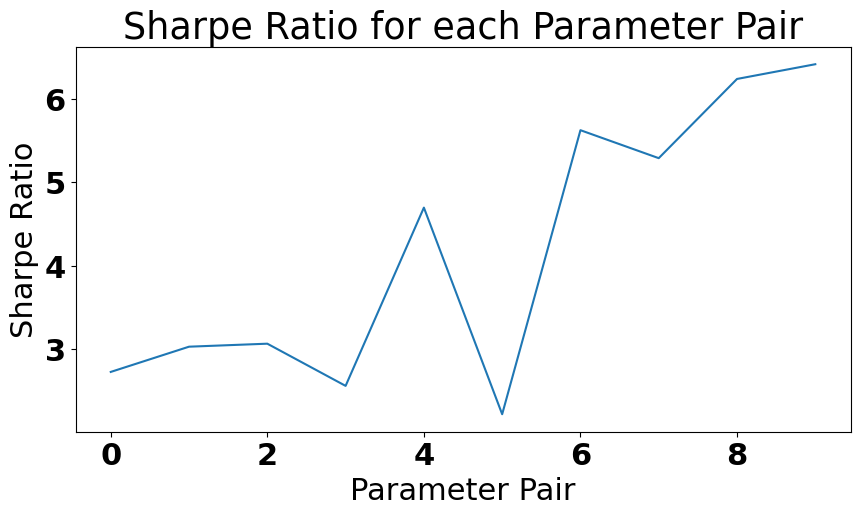

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# calculates SMA using "m" and "n" as the rolling window size
def ma_calc(df, m, n):
  df["sma_short"] = df.Close.rolling(window=min(m,n)).mean()
  df["sma_long"] = df.Close.rolling(window=max(m,n)).mean()
  return df

def backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = ma_calc(df, m, n)
  in_position = False
  daily_profits = []
  capital = starting_capital

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.sma_short > row.sma_long and row.Volume > volume_limit:
          buyprice = row.Close
          investment = min(max(capital * 0.01, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row.sma_short < row.sma_long or row.Close < buyprice * (1 - stop_loss):
          profits.append((row.Close - buyprice) / buyprice)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df[:index])) * daily_profits.mean() / daily_profits.std()

  return hit_rate, profit_factor, sharpe_ratio


# Initialize a dictionary to store metrics for each parameter
metrics_dict = {}

# Run the loop and find the optimal parameters
starting_capital = 10000  # Starting capital in your currency
stop_loss = 0.02  # Stop loss level (2% in this case)
upper_cap = 1000  # Upper investment cap in your currency
lower_cap = 100  # Lower investment cap in your currency
transaction_cost = 0.001  # Transaction cost (0.1% in this case)
leverage = 1 # Leverage (2x in this case)
volume_percentage = 0.2  # Minimum average daily volume

for m in range(19, 76):
  for n in range(2,19 ):
    if m != n:
      hit_rate, profit_factor, sharpe_ratio = backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
      print(f"For parameters: {m} and {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}")
      metrics_dict[(m, n)] = (hit_rate, profit_factor, sharpe_ratio)

# Find the parameter pair with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter pair with maximum Sharpe Ratio is: {max_sharpe_param}")

m, n = max_sharpe_param
df = ma_calc(df, m, n) #adding the feature with optimized parameter

# Plot the Sharpe Ratios
plt.figure(figsize=(10,5))
plt.plot(range(len(metrics_dict)), [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter Pair')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter Pair')
plt.show()


**Window size optimzation for EMA**

For parameter: 2, Hit Rate: 0.030303030303030304, Profit Factor: 0.6065578170911899, Sharpe Ratio: -2.6232684707921794
For parameter: 3, Hit Rate: 0.045454545454545456, Profit Factor: 0.8943677948141471, Sharpe Ratio: -0.7281312808462951
For parameter: 4, Hit Rate: 0.030303030303030304, Profit Factor: 0.9759064131926828, Sharpe Ratio: -0.16415359281087996
For parameter: 5, Hit Rate: 0.07575757575757576, Profit Factor: 1.7767277826384358, Sharpe Ratio: 4.853830144364544
For parameter: 6, Hit Rate: 0.07575757575757576, Profit Factor: 1.9839059945634778, Sharpe Ratio: 5.633986205727331
For parameter: 7, Hit Rate: 0.045454545454545456, Profit Factor: 1.1371540339596466, Sharpe Ratio: 0.9804849214448623
For parameter: 8, Hit Rate: 0.045454545454545456, Profit Factor: 1.5277578048699554, Sharpe Ratio: 3.2184993410024747
For parameter: 9, Hit Rate: 0.015151515151515152, Profit Factor: 0.15568517080109626, Sharpe Ratio: -10.46363212184579
For parameter: 10, Hit Rate: 0.015151515151515152, Prof

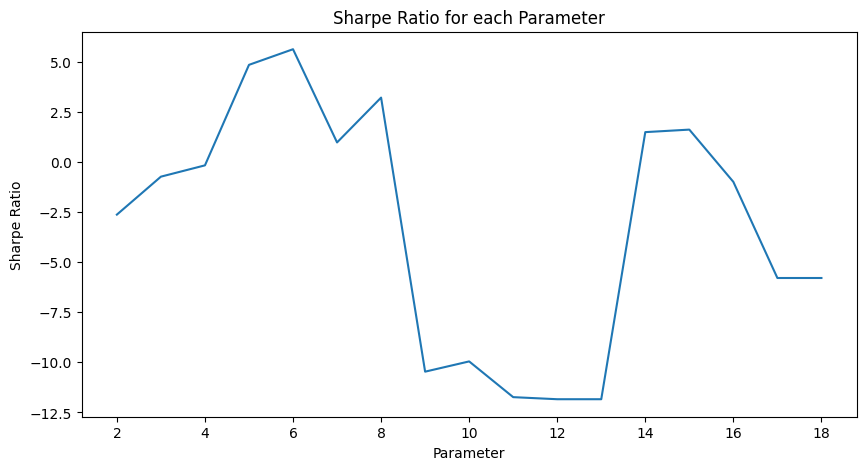

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# calculates EMA using "n" as the rolling window size
def ema_calc(df, n):
  df["ema"] = df.Close.ewm(span=n, adjust=False).mean()
  return df

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = ema_calc(df, n)
  in_position = False
  daily_profits = []
  capital = starting_capital

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.Close > row.ema and row.Volume > volume_limit:
          buyprice = row.Close
          investment = min(max(capital * 0.01, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row.Close < row.ema or row.Close < buyprice * (1 - stop_loss):
          profits.append((row.Close - buyprice) / buyprice)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df[:index])) * daily_profits.mean() / daily_profits.std()

  return hit_rate, profit_factor, sharpe_ratio


# Initialize a dictionary to store metrics for each parameter
metrics_dict = {}

# Run the loop and find the optimal parameters
starting_capital = 10000  # Starting capital in your currency
stop_loss = 0.02  # Stop loss level (2% in this case)
upper_cap = 1000  # Upper investment cap in your currency
lower_cap = 100  # Lower investment cap in your currency
transaction_cost = 0.001  # Transaction cost (0.1% in this case)
leverage = 1 # Leverage (2x in this case)
volume_percentage = 0.2  # Minimum average daily volume

for n in range(2, 19):
  hit_rate, profit_factor, sharpe_ratio = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)  # replace volume_limit with volume_percentage
  print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}")
  metrics_dict[n] = (hit_rate, profit_factor, sharpe_ratio)


# Find the parameter with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter with maximum Sharpe Ratio is: {max_sharpe_param}")

# Add the feature with optimized value
df = ema_calc(df, max_sharpe_param)

# Plot the Sharpe Ratios
plt.figure(figsize=(10,5))
plt.plot(list(metrics_dict.keys()), [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter')
plt.show()


**window optmization for short term and long term EMA crossover**

For parameters: 19 and 2, Hit Rate: 0.030303030303030304, Profit Factor: 0.820021167501057, Sharpe Ratio: -1.3211399982158538
For parameters: 19 and 3, Hit Rate: 0.045454545454545456, Profit Factor: 1.1362861538786067, Sharpe Ratio: 0.9409591410663131
For parameters: 19 and 4, Hit Rate: 0.045454545454545456, Profit Factor: 1.3083657734429777, Sharpe Ratio: 1.6155607757648542
For parameters: 19 and 5, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -11.538710663219328
For parameters: 19 and 6, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -11.538710663219328
For parameters: 19 and 7, Hit Rate: 0.030303030303030304, Profit Factor: 1.7100064449009187, Sharpe Ratio: 3.3087696930200665
For parameters: 19 and 8, Hit Rate: 0.045454545454545456, Profit Factor: 1.9008319626651644, Sharpe Ratio: 3.9760166976943037
For parameters: 19 and 9, Hit Rate: 0.030303030303030304, Profit Factor: 1.9707750005489064, Sharpe Ratio: 4.023082945203606
For parameters: 19 and 10, Hit Rate: 0.0, Profit Factor

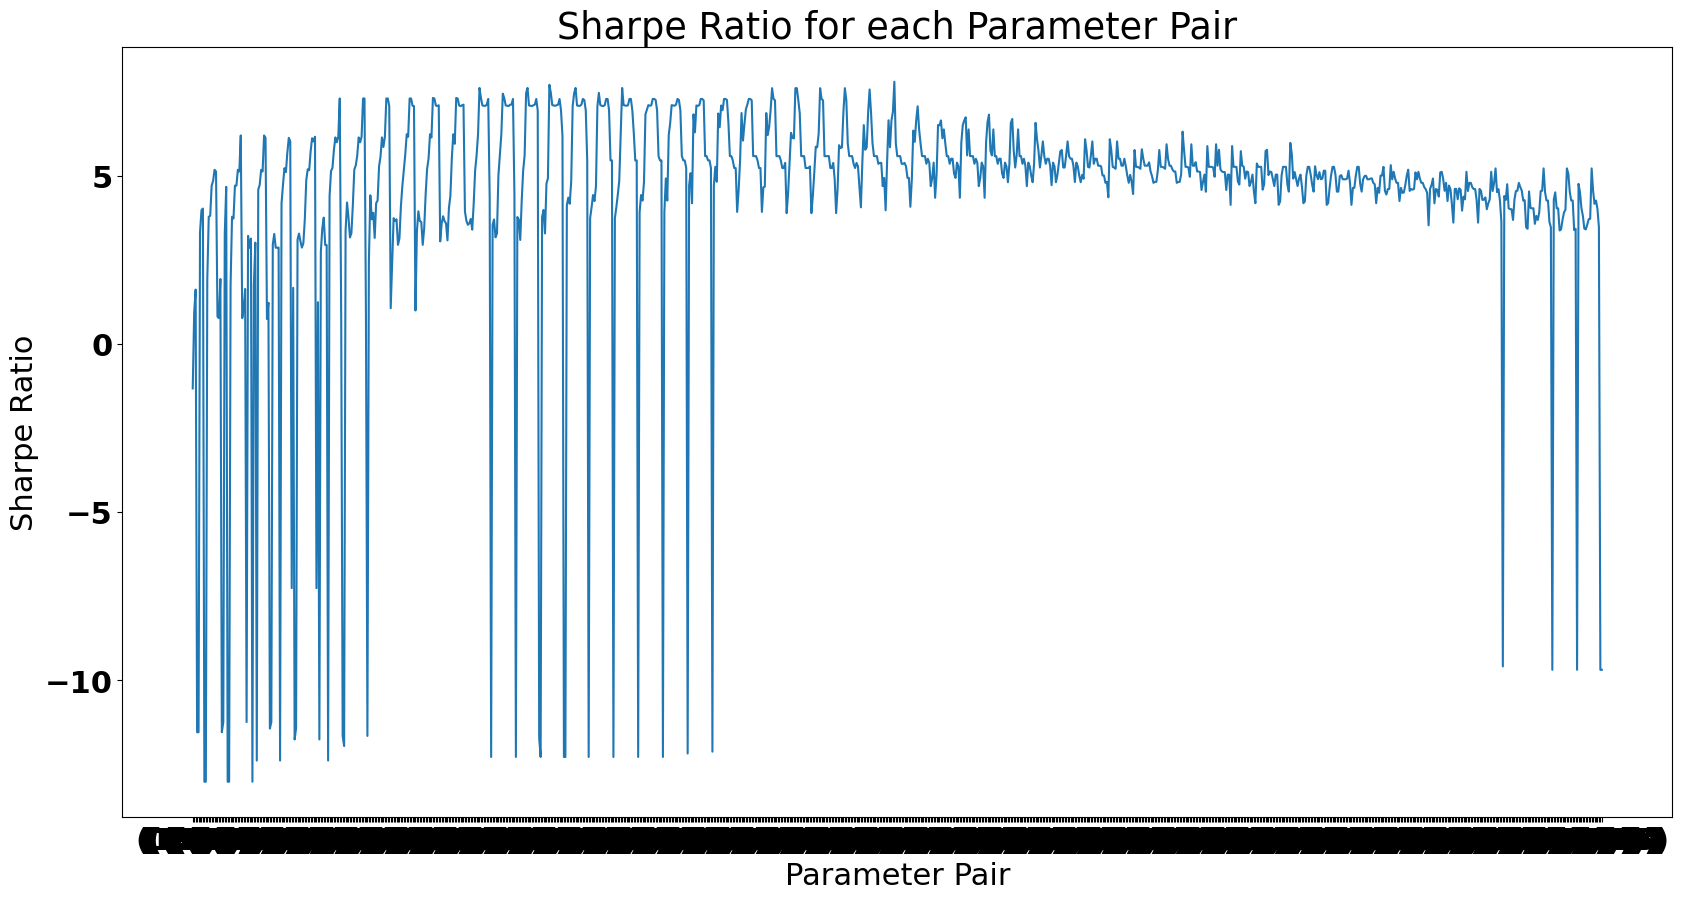

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# calculates EMA using "m" and "n" as the rolling window size
def ema_calc(df, m, n):
  df["ema_short"] = df.Close.ewm(span=min(m,n), adjust=False).mean()
  df["ema_long"] = df.Close.ewm(span=max(m,n), adjust=False).mean()
  return df

def backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = ema_calc(df, m, n)
  in_position = False
  daily_profits = []
  capital = starting_capital

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.ema_short > row.ema_long and row.Volume > volume_limit:
          buyprice = row.Close
          investment = min(max(capital * 0.01, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row.ema_short < row.ema_long or row.Close < buyprice * (1 - stop_loss):
          profits.append((row.Close - buyprice) / buyprice)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df[:index])) * daily_profits.mean() / daily_profits.std()

  return hit_rate, profit_factor, sharpe_ratio


# Initialize a dictionary to store metrics for each parameter pair
metrics_dict = {}

# Run the loop and find the optimal parameters
starting_capital = 10000  # Starting capital in your currency
stop_loss = 0.02  # Stop loss level (2% in this case)
upper_cap = 1000  # Upper investment cap in your currency
lower_cap = 100  # Lower investment cap in your currency
transaction_cost = 0.001  # Transaction cost (0.1% in this case)
leverage = 1 # Leverage (2x in this case)
volume_percentage = 0.2  # Minimum average daily volume

for m in range(19, 76):
  for n in range(2, 19):
    if m != n:
      hit_rate, profit_factor, sharpe_ratio = backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
      print(f"For parameters: {m} and {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}")
      metrics_dict[(m, n)] = (hit_rate, profit_factor, sharpe_ratio)

# Define the weights for each metric
w1 = 0.4 # Weight for hit rate
w2 = 0.3 # Weight for profit factor
w3 = 0.3 # Weight for Sharpe ratio

# Normalize the metrics to have values between 0 and 1
hit_rate_min = min(metrics_dict.values(), key=lambda x: x[0])[0]
hit_rate_max = max(metrics_dict.values(), key=lambda x: x[0])[0]
profit_factor_min = min(metrics_dict.values(), key=lambda x: x[1])[1]
profit_factor_max = max(metrics_dict.values(), key=lambda x: x[1])[1]
sharpe_ratio_min = min(metrics_dict.values(), key=lambda x: x[2])[2]
sharpe_ratio_max = max(metrics_dict.values(), key=lambda x: x[2])[2]

normalized_metrics_dict = {}
for k, v in metrics_dict.items():
  normalized_hit_rate = (v[0] - hit_rate_min) / (hit_rate_max - hit_rate_min)
  normalized_profit_factor = (v[1] - profit_factor_min) / (profit_factor_max - profit_factor_min)
  normalized_sharpe_ratio = (v[2] - sharpe_ratio_min) / (sharpe_ratio_max - sharpe_ratio_min)
  normalized_metrics_dict[k] = (normalized_hit_rate, normalized_profit_factor, normalized_sharpe_ratio)

# Calculate the weighted average score for each parameter pair
score_dict = {}
for k, v in normalized_metrics_dict.items():
  score = w1 * v[0] + w2 * v[1] + w3 * v[2]
  score_dict[k] = score

# Find the parameter pair with maximum score
max_score_param = max(score_dict, key=lambda x: score_dict[x])
print(f"The parameter pair with maximum score is: {max_score_param}")


m, n = max_sharpe_param
df = ema_calc(df, m, n) #adding the feature with optimized parameter

# Plot the Sharpe Ratios
plt.figure(figsize=(20,10))
plt.plot([str(k) for k in metrics_dict.keys()], [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter Pair')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter Pair')
plt.show()


**Window size optimization for RSI**

For parameter: 2, Hit Rate: 0.045454545454545456, Profit Factor: 0.7632390534123018, Sharpe Ratio: -1.863800523409665
For parameter: 3, Hit Rate: 0.030303030303030304, Profit Factor: 0.5549343358781715, Sharpe Ratio: -3.6343503962146424
For parameter: 4, Hit Rate: 0.030303030303030304, Profit Factor: 0.5597772528096188, Sharpe Ratio: -3.4011264197311686
For parameter: 5, Hit Rate: 0.06060606060606061, Profit Factor: 0.8844078237537533, Sharpe Ratio: -0.9196374386246499
For parameter: 6, Hit Rate: 0.12121212121212122, Profit Factor: 2.301426648548438, Sharpe Ratio: 6.8946321566791156
For parameter: 7, Hit Rate: 0.045454545454545456, Profit Factor: 0.8224797969153277, Sharpe Ratio: -1.3933776910514586
For parameter: 8, Hit Rate: 0.07575757575757576, Profit Factor: 1.0351528054466967, Sharpe Ratio: 0.2579096396716885
For parameter: 9, Hit Rate: 0.045454545454545456, Profit Factor: 0.9080929519526723, Sharpe Ratio: -0.6422803291087311
For parameter: 10, Hit Rate: 0.09090909090909091, Profi

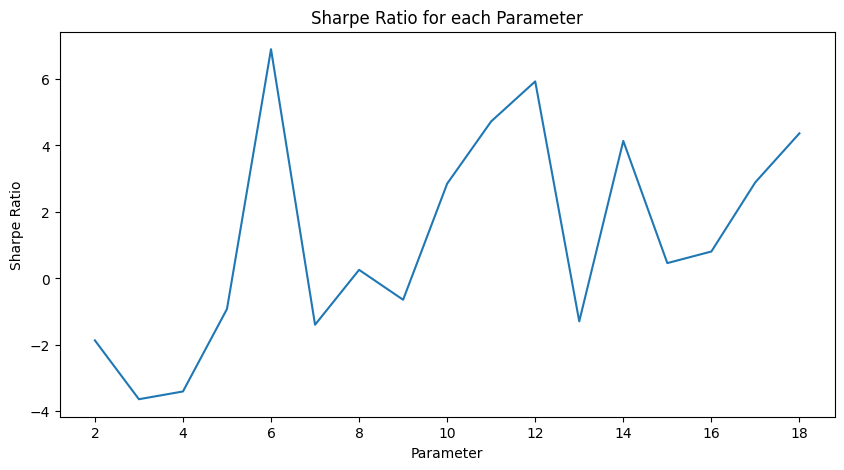

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# calculates RSI using "n" as the lookback period
def rsi_calc(df, n):
  df['rsi'] = 100 - (100 / (1 + df['Close'].diff().apply(lambda x: x if x > 0 else 0).rolling(window=n).mean() / df['Close'].diff().apply(lambda x: -x if x < 0 else 0).rolling(window=n).mean()))
  return df

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = rsi_calc(df, n)
  in_position = False
  daily_profits = []
  capital = starting_capital

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.rsi < 30 and row.Volume > volume_limit:  # RSI is less than 30, oversold condition
          buyprice = row.Close
          investment = min(max(capital * 0.01, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row.rsi > 70 or row.Close < buyprice * (1 - stop_loss):  # RSI is greater than 70, overbought condition
          profits.append((row.Close - buyprice) / buyprice)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df[:index])) * daily_profits.mean() / daily_profits.std()

  return hit_rate, profit_factor, sharpe_ratio


# Initialize a dictionary to store metrics for each parameter
metrics_dict = {}

# Run the loop and find the optimal parameters
starting_capital = 10000  # Starting capital in your currency
stop_loss = 0.02  # Stop loss level (2% in this case)
upper_cap = 1000  # Upper investment cap in your currency
lower_cap = 100  # Lower investment cap in your currency
transaction_cost = 0.001  # Transaction cost (0.1% in this case)
leverage = 1 # Leverage (2x in this case)
volume_percentage = 0.2  # Minimum average daily volume

for n in range(2, 19):
  hit_rate, profit_factor, sharpe_ratio = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)  # replace volume_limit with volume_percentage
  print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}")
  metrics_dict[n] = (hit_rate, profit_factor, sharpe_ratio)


# Find the parameter with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter with maximum Sharpe Ratio is: {max_sharpe_param}")

df = rsi_calc(df, max_sharpe_param) #adding the feature with optimized parameter

# Plot the Sharpe Ratios
plt.figure(figsize=(10,5))
plt.plot(list(metrics_dict.keys()), [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter')
plt.show()


# **OBV**

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# calculates OBV
def obv_calc(df):
  df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
  return df


**Opitmization for MacD**

For parameters: 2 and 3, Hit Rate: 0.09090909090909091, Profit Factor: 1.3751365979372714, Sharpe Ratio: 2.7743938402339507
For parameters: 2 and 4, Hit Rate: 0.07575757575757576, Profit Factor: 1.3656529176540548, Sharpe Ratio: 2.6188627997154863
For parameters: 2 and 5, Hit Rate: 0.07575757575757576, Profit Factor: 1.3277683546756216, Sharpe Ratio: 2.3839547646832906
For parameters: 2 and 6, Hit Rate: 0.07575757575757576, Profit Factor: 1.1596810821475112, Sharpe Ratio: 1.310719118324765
For parameters: 2 and 7, Hit Rate: 0.07575757575757576, Profit Factor: 1.1536990573901529, Sharpe Ratio: 1.2743133117715657
For parameters: 2 and 8, Hit Rate: 0.06060606060606061, Profit Factor: 1.0936507548493462, Sharpe Ratio: 0.7303729351418574
For parameters: 2 and 9, Hit Rate: 0.06060606060606061, Profit Factor: 1.13751904394734, Sharpe Ratio: 1.0177110502732856
For parameters: 2 and 10, Hit Rate: 0.030303030303030304, Profit Factor: 0.1310858466725875, Sharpe Ratio: -8.02795395244242
For parame

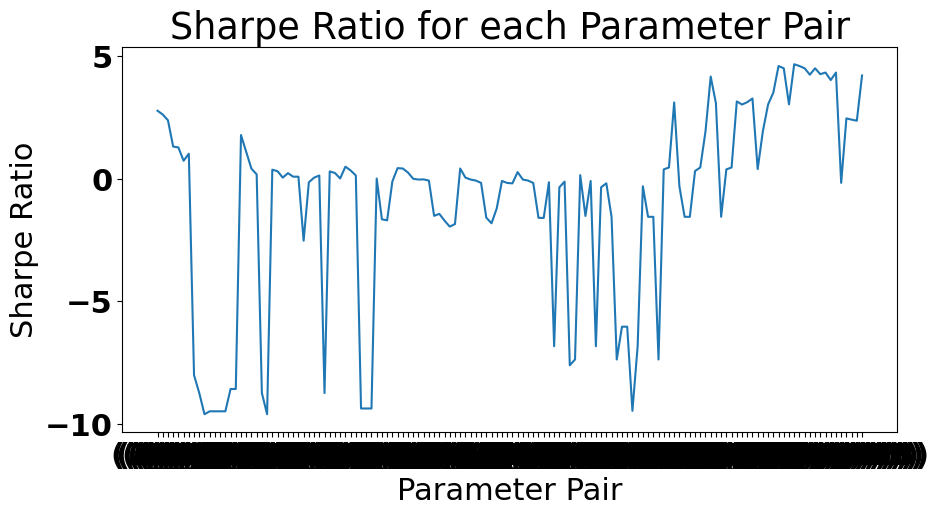

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# calculates MACD
def macd_calc(df, short_window, long_window):
  df["short_ema"] = df.Close.ewm(span=short_window, adjust=False).mean()
  df["long_ema"] = df.Close.ewm(span=long_window, adjust=False).mean()
  df["macd_line"] = df["short_ema"] - df["long_ema"]
  df["signal_line"] = df["macd_line"].ewm(span=6, adjust=False).mean()
  df["macd_histogram"] = df["macd_line"] - df["signal_line"]
  return df

def backtest(df, short_window, long_window, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = macd_calc(df, short_window, long_window)
  in_position = False
  daily_profits = []
  capital = starting_capital

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.macd_line > row.signal_line and row.Volume > volume_limit:  # MACD line crosses above signal line, bullish signal
          buyprice = row.Close
          investment = min(max(capital * 0.01, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row.macd_line < row.signal_line or row.Close < buyprice * (1 - stop_loss):  # MACD line crosses below signal line, bearish signal
          profits.append((row.Close - buyprice) / buyprice)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df[:index])) * daily_profits.mean() / daily_profits.std()

  return hit_rate, profit_factor, sharpe_ratio


# Initialize a dictionary to store metrics for each parameter pair
metrics_dict = {}

# Run the loop and find the optimal parameters
starting_capital = 10000  # Starting capital in your currency
stop_loss = 0.02  # Stop loss level (2% in this case)
upper_cap = 1000  # Upper investment cap in your currency
lower_cap = 100  # Lower investment cap in your currency
transaction_cost = 0.001  # Transaction cost (0.1% in this case)
leverage = 1 # Leverage (2x in this case)
volume_percentage = 0.2  # Minimum average daily volume

for short_window in range(2, 19):
  for long_window in range(short_window+1, 19):
    hit_rate, profit_factor, sharpe_ratio = backtest(df, short_window, long_window, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
    print(f"For parameters: {short_window} and {long_window}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}")
    metrics_dict[(short_window, long_window)] = (hit_rate, profit_factor, sharpe_ratio)

# Find the parameter pair with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter pair with maximum Sharpe Ratio is: {max_sharpe_param}")

short_window, long_window = max_sharpe_param
df = macd_calc(df, short_window, long_window) #adding the feature with optimized parameter

# Plot the Sharpe Ratios
plt.figure(figsize=(10,5))
plt.plot([str(k) for k in metrics_dict.keys()], [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter Pair')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter Pair')
plt.show()


In [21]:
# # Delta features
# df['delta_Close'] = df['Close'].diff()
# df['delta_Volume'] = df['Volume'].diff()

# Crossover features
df['sma_short_over_long'] = np.where(df['sma_short'] > df['sma_long'], 1, -1)
df['ema_short_over_long'] = np.where(df['ema_short'] > df['ema_long'], 1, -1)
df['macd_over_signal'] = np.where(df['macd_line'] > df['signal_line'], 1, -1)
df['price_over_sma'] = np.where(df['Close'] > df['sma'], 1, -1)
df['price_over_ema'] = np.where(df['Close'] > df['ema'], 1, -1)


**Window size optimization for Bollinger Bands**

For parameter: 2, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -8.763543607399766
For parameter: 3, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -8.763543607399766
For parameter: 4, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -8.763543607399766
For parameter: 5, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -8.763543607399766
For parameter: 6, Hit Rate: 0.045454545454545456, Profit Factor: 2.2384019387927774, Sharpe Ratio: 4.841880452297916
For parameter: 7, Hit Rate: 0.16666666666666666, Profit Factor: 2.458205876561978, Sharpe Ratio: 7.613148017609942
For parameter: 8, Hit Rate: 0.15151515151515152, Profit Factor: 1.9874174478058668, Sharpe Ratio: 6.064272501638579
For parameter: 9, Hit Rate: 0.12121212121212122, Profit Factor: 1.8119206715452991, Sharpe Ratio: 5.294110961841047
For parameter: 10, Hit Rate: 0.15151515151515152, Profit Factor: 1.9903869414594169, Sharpe Ratio: 5.998454411226482
For parameter: 11, Hit Rate: 0.15151515151515152, Profit Factor: 2.01990039

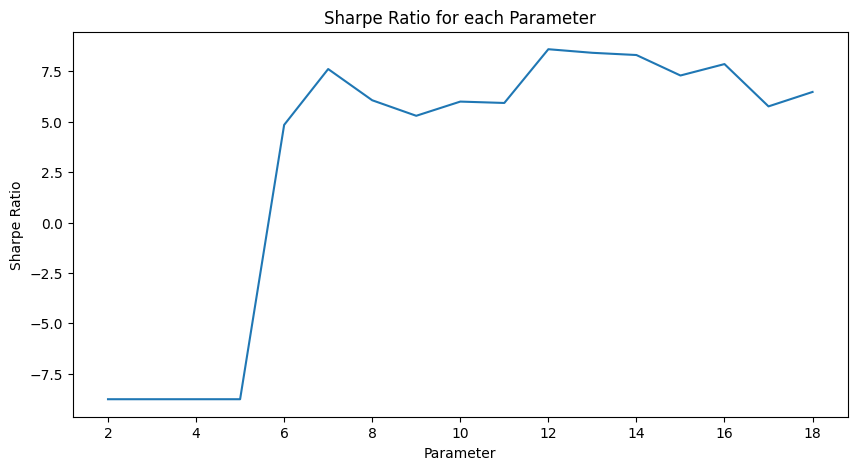

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# calculates Bollinger Bands using "n" as the rolling window size
def bb_calc(df, n):
  df["sma"] = df.Close.rolling(window=n).mean()
  df["std"] = df.Close.rolling(window=n).std()
  df["upper_bb"] = df["sma"] + (2 * df["std"])
  df["lower_bb"] = df["sma"] - (2 * df["std"])
  return df

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = bb_calc(df, n)
  in_position = False
  daily_profits = []
  capital = starting_capital

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.Close > row.lower_bb and row.Volume > volume_limit:  # Price is above lower Bollinger Band
          buyprice = row.Close
          investment = min(max(capital * 0.01, lower_cap), upper_cap)  # Investment per trade
          if investment * buyprice > capital * leverage:
            continue  # Skip if not enough capital
          capital -= investment * buyprice * (1 + transaction_cost)  # Deduct investment and transaction cost from capital
          in_position = True

      if in_position:
        if row.Close > row.upper_bb or row.Close < buyprice * (1 - stop_loss):  # Price is above upper Bollinger Band or stop loss is hit
          profits.append((row.Close - buyprice) / buyprice)
          capital += investment * row.Close * (1 - transaction_cost)  # Add selling proceeds after transaction cost to capital
          in_position = False

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()

  return hit_rate, profit_factor, sharpe_ratio


# Initialize a dictionary to store metrics for each parameter
metrics_dict = {}

# Run the loop and find the optimal parameters
starting_capital = 10000  # Starting capital in your currency
stop_loss = 0.02  # Stop loss level (2% in this case)
upper_cap = 1000  # Upper investment cap in your currency
lower_cap = 100  # Lower investment cap in your currency
transaction_cost = 0.001  # Transaction cost (0.1% in this case)
leverage = 1 # Leverage (2x in this case)
volume_percentage = 0.2  # Minimum average daily volume

for n in range(2, 19):
  hit_rate, profit_factor, sharpe_ratio = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)  # replace volume_limit with volume_percentage
  print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}")
  metrics_dict[n] = (hit_rate, profit_factor, sharpe_ratio)


# Find the parameter with maximum Sharpe Ratio
max_sharpe_param = max(metrics_dict, key=lambda x: metrics_dict[x][2])
print(f"The parameter with maximum Sharpe Ratio is: {max_sharpe_param}")

df = bb_calc(df, max_sharpe_param) #adding the feature with optimized parameter

# Plot the Sharpe Ratios
plt.figure(figsize=(10,5))
plt.plot(list(metrics_dict.keys()), [metrics_dict[p][2] for p in metrics_dict])
plt.xlabel('Parameter')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio for each Parameter')
plt.show()


In [23]:
df['pullback'] = np.where(df['Close'] < df['sma_short'], 1, 0)

In [24]:
# Create a new column 'Close_next' which is the next period's closing price
df['Close_next'] = df['Close'].shift(-1)

# Create two new columns 'uptrend' and 'downtrend'
df['target'] = (df['Close_next'] > df['Close']).astype(int)


# Drop the 'Close_next' column as we don't need it anymore
df.drop('Close_next', axis=1, inplace=True)

# Create 7 lag columns for closing price
for i in range(1, 8):
    df[f'Close_lag_{i}'] = df['Close'].shift(i)


In [25]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'sma', 'sma_short',
       'sma_long', 'ema', 'ema_short', 'ema_long', 'rsi', 'short_ema',
       'long_ema', 'macd_line', 'signal_line', 'macd_histogram', 'delta_Close',
       'delta_Volume', 'sma_short_over_long', 'ema_short_over_long',
       'macd_over_signal', 'price_over_sma', 'price_over_ema', 'std',
       'upper_bb', 'lower_bb', 'pullback', 'target', 'Close_lag_1',
       'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5',
       'Close_lag_6', 'Close_lag_7'],
      dtype='object')

In [26]:
df2=df.copy()

In [27]:
df=df2.copy()
df=obv_calc(df)

# **Vizualizations start from here**

**using matplotlib and ipywidgets**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

**Uncomment the code below to add Custom Crossover between two columns**

In [ ]:
# df["Delta"]=df["sma"]-df["Close"]

**Uncomment the code below to MinMaxScale between 0 to 1. However,I do not see the need to do so unless passing it to an ML Model**

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# numerical_cols = df.columns[df.dtypes != 'datetime64[ns]']

# scaler = MinMaxScaler()
# df = df.copy()
# df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
# df

In [29]:
df.reset_index(level=0, inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, SelectMultiple, SelectionRangeSlider
from datetime import datetime

# callable plotting function
def plot_df(columns, date_range):
    if columns:  # Check if any column is selected
        fig, ax = plt.subplots(figsize=(50, 20))  # Create a figure and a set of subplots
        df.set_index('Date').loc[date_range[0]:date_range[1], list(columns)].plot(ax=ax)  # Plot on the specific axes
        ax.grid(True)
        ax.legend(fontsize="40")  # Increase the legend size

        font = {'weight' : 'bold',
                'size'   : 22}

        plt.rc('font', **font)
        plt.show()

# Getting column names from the dfFrame
column_names = [col for col in df.columns.tolist() if col != 'Date']

# Here creating date range slider
dates = pd.date_range(df['Date'].min(), df['Date'].max(), freq='D')
options = [(date.strftime(' %d %b %Y '), date) for date in dates]
date_range_slider = SelectionRangeSlider(
    options=options,
    index=(0, len(options)-1),
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

# Plotting interactive plot
interact(plot_df, columns=SelectMultiple(options=column_names), date_range=date_range_slider)


interactive(children=(SelectMultiple(description='columns', options=('Open', 'High', 'Low', 'Close', 'Volume',…

<function __main__.plot_df(columns, date_range)>